In [1]:
import os
import pickle
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torch
import torchvision

#### Loading data

In [2]:
with open('./data/latest_states.data', 'rb') as f:
    latents = pickle.load(f)
    
with open('./data/rewards.data', 'rb') as f:
    rewards = pickle.load(f)
    
with open('./data/full_states_0.data', 'rb') as f:
    fulls0 = pickle.load(f)

with open('./data/full_states_1.data', 'rb') as f:
    fulls1 = pickle.load(f)
    
with open('./data/full_states_2.data', 'rb') as f:
    fulls2 = pickle.load(f)
    
fulls = []

for i in [fulls0, fulls1, fulls2]:
    for j in i:
        fulls.append(j)
        
rewards_flat = []
for i in rewards:
    for j in i:
        rewards_flat.append(j)

In [3]:
# scaled_rewards = []

# for i in range(len(rewards)):
#     scaled_rewards.append(
#         [x if x <10 else 1 for x in rewards[i]]
#     )

scaled_rewards = [x if x < 10 else 1 for x in rewards_flat]

In [4]:
len(scaled_rewards)

1464

In [54]:
pca = PCA(3)

In [57]:
x = pca.fit_transform(np.array(latents[0]))

In [33]:
len(rewards_flat)

1464

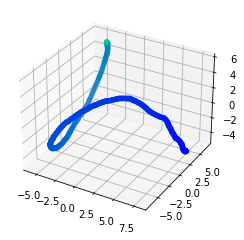

In [59]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
# plt.title('PCA: Hidden Space of Random Policy (Images)')
ax.scatter(xs=x[:, 0], 
           ys=x[:, 1], 
           zs=x[:, 2], 
           c=scaled_rewards[0], cmap='winter')

#### Model

In [112]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3, 16, (5,5), 2)
        self.c2 = nn.Conv2d(16, 8, (5,5), 2)
        self.c3 = nn.Conv2d(8, 1, (5, 5), 2)
        self.d1 = nn.Linear(625, 32)
        
    def single_forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = x.view(x.size(0), -1)
        return self.d1(x)
    
    def forward(self, xs):
        x1 = self.single_forward(xs[0])
        x2 = self.single_forward(xs[1])
        return x1, x2
 
class PolicyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3, 8, (5, 5), stride=2)
        self.c2 = nn.Conv2d(8, 4, (5, 5), stride=2)
        self.c3 = nn.Conv2d(4, 1, (5, 5), stride=2)
        self.d1 = nn.Linear(625, 32)

        self.action_head = nn.Linear(32, 7)
        self.value_head = nn.Linear(32, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []
    
    def base(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = x.view(x.size(0), -1)
        return self.d1(x)
    
    def siamese(self, xs):
        out1 = self.base(xs[0])
        out2 = self.base(xs[1])
        return out1, out2
    
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.d1(x))


        # actor: choses action to take from state s_t
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tupel of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, state_values

class CNNEncoder(nn.Module):
    """"""
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3, 8, (5, 5), stride=2)
        self.c2 = nn.Conv2d(8, 4, (5, 5), stride=2)
        self.c3 = nn.Conv2d(4, 1, (5, 5), stride=2)
        self.d1 = nn.Linear(625, 32)
        
    def base(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = x.view(x.size(0), -1)
        return self.d1(x)
    
    def siamese(self, xs):
        out1 = self.base(xs[0])
        out2 = self.base(xs[1])
        return out1, out2
    
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = x.view(x.size(0), -1)
        x = self.d1(x)

In [144]:
model = CNNEncoder()

rnd_model = CNNEncoder()
# rnd_model.load_state_dict(model.state_dict())

#### Loss function

In [145]:
class NormLoss(nn.Module):
    def __init__(self, norm):
        super().__init__()
        self.norm = norm
        
    def forward(self, out1, out2, rs):
        l1 = F.pairwise_distance(out1, out2, self.norm)
        return torch.mean((l1 - rs)**2)

In [146]:
class CosineLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, out1, out2, rs):
        cos = torch.diagonal(torch.matmul(out1, out2.T)) / (torch.linalg.norm(out1, 2, dim=1) * torch.linalg.norm(out2, 2, dim=1))
        return torch.mean((cos - rs)**2)

In [147]:
loss_fn = NormLoss(1)
# loss_fn = CosineLoss()

In [148]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Training

In [149]:
MBS = 10
batch_size = 64
loss_hist = []

for i in tqdm(range(MBS)):
    idxs = [np.random.choice(len(rewards_flat), 2, replace=False) for _ in range(batch_size)]
    rs = np.array(scaled_rewards)[idxs]
    rs = torch.tensor(np.abs(rs[:,0] - rs[:,1])).float()
    xs = np.array(fulls)[idxs]
    xs = torch.tensor(np.moveaxis(xs, -1, 2)).float()
    x1 = xs[:, 0, :, :, :]
    x2 = xs[:, 1, :, :, :]
    out1, out2 = model.siamese([x1, x2])
    
    loss = loss_fn(out1, out2, rs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())

100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


In [165]:
np.array(scaled_rewards)[idxs]

array([[-4.28420862, -4.60013452],
       [-2.79629887, -4.26050436],
       [-2.07073608, -3.1756875 ],
       [-3.25252167, -3.07624578],
       [-5.09046925, -3.32963332],
       [-5.19118862, -4.24470665],
       [-1.91442182, -3.98474493],
       [-3.53131122, -3.87488837],
       [-3.50795917, -3.82789562],
       [-3.79659866, -3.87488837],
       [-4.41079708, -2.02905991],
       [-5.49195738, -4.68497095],
       [-5.01467818, -2.03602408],
       [-2.93945119, -2.83383912],
       [-4.33955931, -2.30391685],
       [-5.41164958, -2.5290634 ],
       [-5.32553718, -2.17603255],
       [-2.59534695, -2.58058341],
       [-5.26851965, -3.56247925],
       [-4.33955931, -3.24482589],
       [-5.50622167, -3.50017908],
       [-3.68726902, -4.22101793],
       [-2.07073608, -4.00832241],
       [-4.46625955, -5.63149189],
       [-3.78877951, -5.00165764],
       [-3.19103134, -2.23249009],
       [-3.20638681, -3.80442153],
       [-2.87901321, -5.15272202],
       [-2.8714747 ,

In [171]:
xs[0].shape

torch.Size([2, 3, 224, 224])

In [172]:
np.array(fulls).shape

(1464, 224, 224, 3)

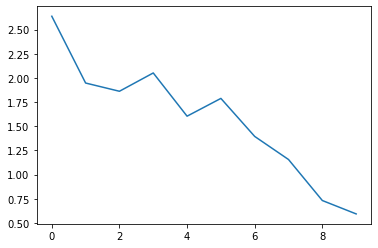

In [150]:
plt.plot(loss_hist)
# plt.ylim(0.0, 0.1)

In [151]:
F.pairwise_distance(out1, out2, 1)

tensor([0.1877, 1.0277, 1.3400, 0.2485, 0.8867, 0.4696, 1.4565, 0.2454, 0.2426,
        0.0675, 1.5013, 0.2659, 1.3211, 0.1567, 1.4376, 1.0278, 1.2571, 0.0417,
        0.8197, 0.7356, 0.8094, 0.3591, 1.5280, 0.3792, 0.7051, 1.2470, 0.5381,
        0.9267, 0.3042, 0.7493, 0.1917, 0.4734, 0.5519, 0.5117, 0.8806, 0.2991,
        1.2620, 0.5779, 0.9848, 0.1992, 0.5421, 0.2703, 0.4327, 1.2180, 1.2527,
        0.1195, 1.1911, 1.2599, 0.3189, 0.8454, 0.0834, 0.5949, 0.4573, 0.7603,
        1.5376, 1.4279, 1.3290, 0.2903, 1.0328, 1.0305, 0.8679, 1.4963, 1.4655,
        0.0981], grad_fn=<NormBackward1>)

In [152]:
torch.diagonal(torch.matmul(out1, out2.T)) / (torch.linalg.norm(out1, 2, dim=1) * torch.linalg.norm(out2, 2, dim=1))

tensor([0.9905, 0.7420, 0.5056, 0.9851, 0.8324, 0.9427, 0.4410, 0.9861, 0.9868,
        0.9991, 0.3811, 0.9756, 0.4689, 0.9938, 0.4490, 0.6774, 0.5138, 0.9995,
        0.8548, 0.8732, 0.8542, 0.9717, 0.3704, 0.9575, 0.8954, 0.5840, 0.9365,
        0.7737, 0.9747, 0.8811, 0.9824, 0.9378, 0.9251, 0.9330, 0.8044, 0.9824,
        0.4956, 0.9161, 0.7270, 0.9850, 0.9131, 0.9847, 0.9444, 0.5495, 0.5650,
        0.9967, 0.5479, 0.5010, 0.9713, 0.7343, 0.9975, 0.9152, 0.9469, 0.8693,
        0.3764, 0.4803, 0.5306, 0.9749, 0.7144, 0.7679, 0.8335, 0.4005, 0.4105,
        0.9967], grad_fn=<DivBackward0>)

In [153]:
rs

tensor([0.3159, 1.4642, 1.1050, 0.1763, 1.7608, 0.9465, 2.0703, 0.3436, 0.3199,
        0.0783, 2.3817, 0.8070, 2.9787, 0.1056, 2.0356, 2.8826, 3.1495, 0.0148,
        1.7060, 1.0947, 2.0060, 0.5337, 1.9376, 1.1652, 1.2129, 0.9585, 0.5980,
        2.2737, 0.2021, 0.5849, 0.1113, 1.1122, 1.0379, 0.9976, 0.6960, 0.3847,
        3.3214, 0.4223, 0.7055, 0.7948, 0.3381, 0.3922, 1.0303, 2.3493, 2.0062,
        0.0684, 3.0453, 3.1937, 0.2324, 0.6483, 0.3098, 1.1212, 0.8617, 0.8686,
        1.9373, 1.5689, 1.8770, 0.1772, 0.7382, 1.0296, 2.3546, 2.1960, 2.4144,
        0.1121])

In [154]:
outs = []
outs_rnd = []
for i in tqdm(range(len(fulls))):
    img = np.moveaxis(fulls[i], -1, 0)
    img = torch.tensor(img).unsqueeze(0).float()
    out = model.base(img)
    outs.append(out.detach().numpy()[0])
    
    out_rnd = rnd_model.base(img)
    outs_rnd.append(out_rnd.detach().numpy()[0])

100%|██████████| 1464/1464 [00:04<00:00, 298.61it/s]


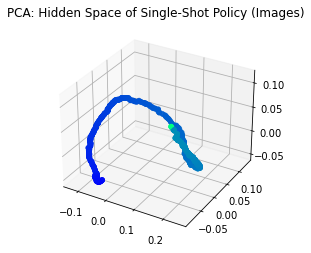

In [155]:
pca = PCA(3)
x = pca.fit_transform(np.array(outs))
fig = plt.figure()
ax = plt.axes(projection ='3d')
plt.title('PCA: Hidden Space of Single-Shot Policy (Images)')
ax.scatter(xs=x[:, 0], 
           ys=x[:, 1], 
           zs=x[:, 2], 
           c=scaled_rewards, cmap='winter')

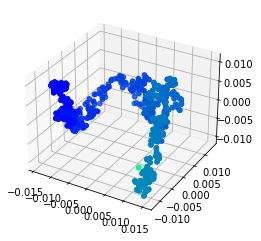

In [156]:
pca = PCA(3)
x = pca.fit_transform(np.array(outs_rnd))
fig = plt.figure()
ax = plt.axes(projection ='3d')
# plt.title('PCA: Hidden Space of Random Policy (Images)')
ax.scatter(xs=x[:, 0], 
           ys=x[:, 1], 
           zs=x[:, 2], 
           c=scaled_rewards, cmap='winter')

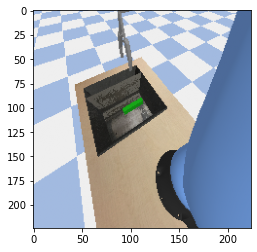

In [103]:
plt.imshow(fulls[0])

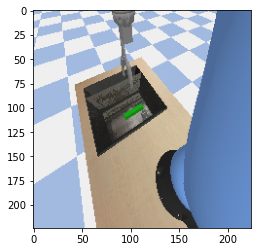

In [106]:
plt.imshow(fulls[88])

In [157]:
torch.save(model.state_dict(), './data/10_encoder_32_l1.pth')

In [191]:
!ls ./data

10_fewshot_32_0.pth  full_states_1.data  latest_states.data
full_states_0.data   full_states_2.data  rewards.data


In [125]:
model.load_state_dict(torch.load('./data/100_fewshot_0.pth'))
model.state_dict()

OrderedDict([('c1.weight',
              tensor([[[[-0.0433,  0.1116, -0.0376],
                        [ 0.1452, -0.0819, -0.0624],
                        [ 0.1865,  0.1034, -0.1185]],
              
                       [[-0.0889,  0.0283,  0.0902],
                        [ 0.1812, -0.0476,  0.1102],
                        [ 0.0226, -0.1471,  0.0833]],
              
                       [[-0.0169,  0.1405, -0.0966],
                        [-0.1883,  0.1724, -0.0310],
                        [-0.1433, -0.0364, -0.1696]]],
              
              
                      [[[-0.1358, -0.0038, -0.0101],
                        [ 0.0297,  0.1351,  0.1799],
                        [-0.0790,  0.0606,  0.1781]],
              
                       [[ 0.1192,  0.1675, -0.0075],
                        [-0.0932, -0.1230,  0.1053],
                        [ 0.0773,  0.0365, -0.0221]],
              
                       [[ 0.1456, -0.1461,  0.0829],
                        [-0.1

In [131]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[-0.0433,  0.1116, -0.0376],
          [ 0.1452, -0.0819, -0.0624],
          [ 0.1865,  0.1034, -0.1185]],

         [[-0.0889,  0.0283,  0.0902],
          [ 0.1812, -0.0476,  0.1102],
          [ 0.0226, -0.1471,  0.0833]],

         [[-0.0169,  0.1405, -0.0966],
          [-0.1883,  0.1724, -0.0310],
          [-0.1433, -0.0364, -0.1696]]],


        [[[-0.1358, -0.0038, -0.0101],
          [ 0.0297,  0.1351,  0.1799],
          [-0.0790,  0.0606,  0.1781]],

         [[ 0.1192,  0.1675, -0.0075],
          [-0.0932, -0.1230,  0.1053],
          [ 0.0773,  0.0365, -0.0221]],

         [[ 0.1456, -0.1461,  0.0829],
          [-0.1269, -0.1228,  0.0902],
          [-0.0332, -0.1701,  0.1638]]],


        [[[ 0.1639,  0.1483,  0.0567],
          [ 0.1472,  0.1241, -0.1530],
          [ 0.1098,  0.0201, -0.0233]],

         [[ 0.0644,  0.0283, -0.1188],
          [-0.0275,  0.0704,  0.1928],
          [-0.0596, -0.0300, -0.1340]],

         [[ 0.0956,  0

In [136]:
model

PolicyCNN(
  (c1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
  (c2): Conv2d(8, 4, kernel_size=(3, 3), stride=(2, 2))
  (c3): Conv2d(4, 1, kernel_size=(3, 3), stride=(2, 2))
  (d1): Linear(in_features=729, out_features=64, bias=True)
  (action_head): Linear(in_features=64, out_features=7, bias=True)
  (value_head): Linear(in_features=64, out_features=1, bias=True)
)